In [36]:
import itertools
import numpy as np
import seaborn as sns
from scipy.optimize import minimize, minimize_scalar
from matplotlib import pyplot as plt

In [37]:
class OptimizedFunction:
    def __init__(self, f, name, x_min, x_max):
        self._f = f
        self.name = name
        self._n_calls = 0
        self.x_min = x_min
        self.x_max = x_max

    def __call__(self, *args, **kwargs):
        self._n_calls += 1
        return self._f(*args, **kwargs)

    def call_count(self):
        return self._n_calls

    def reset(self):
        self._n_calls = 0

In [38]:
def f1(x):
    return x**3

def f2(x):
    return abs(x - 0.2)

def f3(x):
    return x * np.sin(1/x)

In [39]:
opt1 = OptimizedFunction(f1, 'x^3', 0, 1)
opt2 = OptimizedFunction(f2, '|x-0.2|', 0, 1)
opt3 = OptimizedFunction(f3, 'x*sin(1/x)', 0.01, 1)

In [44]:
def linear_search(f, x_min, x_max, eps):
    net = np.arange(x_min, x_max, step=eps)
    function_values = np.array([f(x) for x in net])
    argmin = np.argmin(function_values)
    
    return net[argmin], len(net)

In [45]:
def dichotomy(f, x_min, x_max, eps):
    delta = eps/3
    
    x_l = x_min
    x_r = x_max
    i = 0
    
    while abs(x_l - x_r) > eps:
        x_mid = (x_l + x_r)/2
        x_1 = x_mid - delta
        x_2 = x_mid + delta
        
        if f(x_1) <= f(x_2):
            x_r = x_2
        else:
            x_l = x_1
        i += 1
        
    return x_l, i

In [46]:
invphi2 = (3 - np.sqrt(5))/2

def golden_section(f, x_min, x_max, eps):
    x_l = x_min
    x_r = x_max
    
    x_1 = x_l + invphi2 * (x_r - x_l)
    x_2 = x_r - invphi2 * (x_r - x_l)
    f_1 = f(x_1)
    f_2 = f(x_2)
    
    i = 1
    while abs(x_l - x_r) > eps:
        if f_1 < f_2:
            x_r = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = x_l + invphi2 * (x_r - x_l)
            f_1 = f(x_1)
        else:
            x_l = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = x_r - invphi2 * (x_r - x_l)
            f_2 = f(x_2)
        i += 1
    
    return x_l, i

In [53]:
eps = 1e-3

for optimizer in [linear_search, dichotomy, golden_section]:
    print(optimizer.__name__, '\n')
    for objective in [opt1, opt2, opt3]:
        objective.reset()
        _, n_iters = optimizer(objective, objective.x_min, objective.x_max, eps)
        n_evals = objective.call_count()
        print(f'{objective.name} : iterations={n_iters}, evaluations={n_evals}')
    print('\n------------------------------------------------\n')

linear_search 

x^3 : iterations=1000, evaluations=1000
|x-0.2| : iterations=1000, evaluations=1000
x*sin(1/x) : iterations=990, evaluations=990

------------------------------------------------

dichotomy 

x^3 : iterations=12, evaluations=24
|x-0.2| : iterations=12, evaluations=24
x*sin(1/x) : iterations=12, evaluations=24

------------------------------------------------

golden_section 

x^3 : iterations=16, evaluations=17
|x-0.2| : iterations=16, evaluations=17
x*sin(1/x) : iterations=16, evaluations=17

------------------------------------------------



In [54]:
def linear_approx(x, a, b):
    return a*x + b

def rational_approx(x, a, b):
    return a/(1 + b*x)

In [55]:
def loss(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

In [115]:
alpha = np.random.rand()
beta = np.random.rand()

print(alpha, beta)

x = np.arange(0, 1.01, step=0.01)
y = alpha*x + beta + np.random.normal(loc=0, scale=1, size=x.shape)

def linear_loss(params):
    a, b = params
    return loss(F(x, a, b), y)
    
def rational_loss(params):
    a, b = params
    return loss(G(x, a, b), y)

0.3919451220418142 0.5292762905133975


In [116]:
def linear_search_2d(f, x_min, x_max, y_min, y_max, eps):
    X = np.arange(x_min, x_max, step=eps)
    Y = np.arange(y_min, y_max, step=eps)
    
    f_argmin = None
    f_min = np.inf
    
    for p in itertools.product(X, Y):
        f_cur = f(p)
        if f_cur < f_min:
            f_min = f_cur
            f_argmin = p
    return f_argmin

In [117]:
def __fix_x(f, x):
    return lambda y: f((x, y))

def __fix_y(f, y):
    return lambda x: f((x, y))

def gauss_opt(f, x_0, y_0, eps):
    x = x_0
    y = y_0
    
    f_y = __fix_y(f, y)
    x_new = minimize_scalar(f_y).x
    f_x = __fix_x(f, x_new)
    y_new = minimize_scalar(f_x).x
    
    while max(x-x_new, y-y_new) > eps:
        x = x_new
        y = y_new
        
        f_y = __fix_y(f, y)
        x_new = minimize_scalar(f_y).x
        f_x = __fix_x(f, x_new)
        y_new = minimize_scalar(f_x).x
    
    return x, y

In [118]:
def nelder_mead(f, x_0, y_0, eps):
    return minimize(f, method='Nelder-Mead', x0=(x_0, y_0), tol=eps).x

In [119]:
alpha_1, beta_1 = linear_search_2d(linear_loss, 0, 1, 0, 1, 0.001)
alpha_2, beta_2 = gauss_opt(linear_loss, 0.5, 0.5, 0.0001)
alpha_3, beta_3 = nelder_mead(linear_loss, 0.5, 0.5, 0.001)

print(f'Exhaustive:           alpha={alpha_1:.4}, beta={beta_1:.4}')
print(f'Gauss:                alpha={alpha_2:.4}, beta={beta_2:.4}')
print(f'Nelder-Mead:          alpha={alpha_3:.4}, beta={beta_3:.4}')

Exhaustive:           alpha=0.258, beta=0.426
Gauss:                alpha=0.2581, beta=0.4261
Nelder-Mead:          alpha=0.2591, beta=0.4256


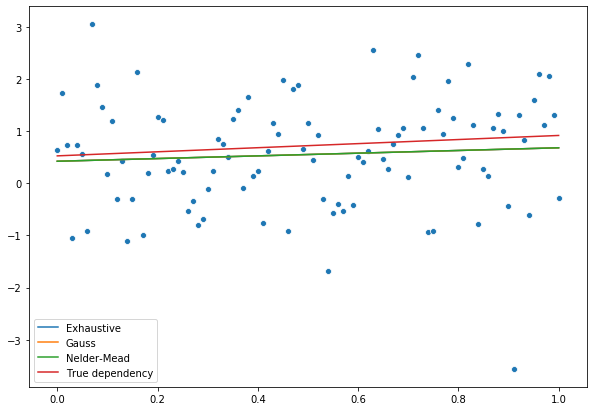

In [120]:
y_pred_1 = linear_approx(x, alpha_1, beta_1)
y_pred_2 = linear_approx(x, alpha_2, beta_2)
y_pred_3 = linear_approx(x, alpha_3, beta_3)
y_true = linear_approx(x, alpha, beta)

plt.figure(figsize=(10, 7))
sns.scatterplot(x, y)
plt.plot(x, y_pred_1, label='Exhaustive')
plt.plot(x, y_pred_2, label='Gauss')
plt.plot(x, y_pred_3, label='Nelder-Mead')
plt.plot(x, y_true, label='True dependency')
plt.legend()
plt.savefig('linear_app.png')
plt.show()

In [128]:
print(f'mean_error_1 = {np.mean(abs(y_pred_1-y_true)):.4}')
print(f'mean_error_2 = {np.mean(abs(y_pred_2-y_true)):.4}')
print(f'mean_error_3 = {np.mean(abs(y_pred_3-y_true)):.4}')

mean_error_1 = 0.1702
mean_error_2 = 0.1701
mean_error_3 = 0.1701


In [122]:
alpha_4, beta_4 = linear_search_2d(rational_loss, 0, 1, -0.5, 1, 0.001)
alpha_5, beta_5 = gauss_opt(rational_loss, 0.5, 0.5, 0.0001)
alpha_6, beta_6 = nelder_mead(rational_loss, 0.5, 0.5, 0.001)

print(f'Exhaustive:           alpha={alpha_4:.4}, beta={beta_4:.4}')
print(f'Gauss:                alpha={alpha_5:.4}, beta={beta_5:.4}')
print(f'Nelder-Mead:          alpha={alpha_6:.4}, beta={beta_6:.4}')

Exhaustive:           alpha=0.424, beta=-0.428
Gauss:                alpha=0.4246, beta=-0.4271
Nelder-Mead:          alpha=0.4246, beta=-0.4273


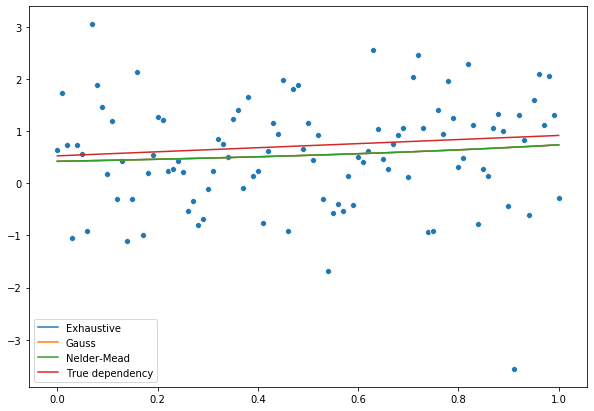

In [123]:
y_pred_4 = rational_approx(x, alpha_4, beta_4)
y_pred_5 = rational_approx(x, alpha_5, beta_5)
y_pred_6 = rational_approx(x, alpha_6, beta_6)
y_true = linear_approx(x, alpha, beta)

plt.figure(figsize=(10, 7))
sns.scatterplot(x, y)
plt.plot(x, y_pred_4, label='Exhaustive')
plt.plot(x, y_pred_5, label='Gauss')
plt.plot(x, y_pred_6, label='Nelder-Mead')
plt.plot(x, y_true, label='True dependency')
plt.legend()
plt.savefig('rational.png')
plt.show()

In [124]:
print(f'max_error_1 = {np.mean(abs(y_pred_4-y_true)):.4}')
print(f'max_error_2 = {np.mean(abs(y_pred_5-y_true)):.4}')
print(f'max_error_3 = {np.mean(abs(y_pred_6-y_true)):.4}')

max_error_1 = 0.1988
max_error_2 = 0.1984
max_error_3 = 0.1984
